In [1]:
from cell_model import GraphEvolution

from cell_training import run_single, run_single_recursive

import torch

import pickle as pkl

c:\Users\gille\miniconda3\envs\geom\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = GraphEvolution(in_channels=4, out_channels=4, hidden_channels=32, dropout=0.05, edge_dim=2+4+4*2, messages=3, wrap=True)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rval, edge_index, edge_attr, batch_edge, border, params = pkl.load(open('sample.pkl', 'rb'))

good_prediction = torch.concat((torch.zeros_like(rval[:,:,:4]), torch.zeros_like(rval[:,:,:4])), dim=2)
good_prediction[:, :, ::2] = rval[:, :, :4]
good_prediction[:, :, 1::2] = good_prediction[:, :, 1::2]  - 5

medium_prediction = torch.clone(good_prediction)
medium_prediction[:, :, 1::2] = medium_prediction[:, :, 1::2]  + 1

bad_prediction = torch.clone(good_prediction)
bad_prediction[:, :, 1::2] = bad_prediction[:, :, 1::2]  + 2

tensor(0.0067)
tensor(0.0183)
tensor(0.0498)
Loss0 : tensor(-376474., requires_grad=True)
Loss1 : tensor(-292327.0312, requires_grad=True)
Loss2 : tensor(-209297.0469, requires_grad=True)


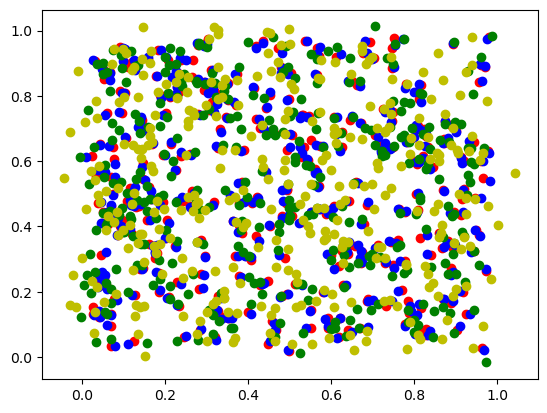

In [4]:
loss0, out0 = model.loss_direct(good_prediction, rval[:,:,:4])
loss1, out1 = model.loss_direct(medium_prediction, rval[:,:,:4])
loss2, out2 = model.loss_direct(bad_prediction, rval[:,:,:4])

print("Loss0 :", loss0)
print("Loss1 :", loss1)
print("Loss2 :", loss2)

#scatter the first two channels of each for time step 0
import matplotlib.pyplot as plt 

plt.scatter(rval[0,:,0], rval[0,:,1], c='r')
plt.scatter(out0[0,:,0], out0[0,:,1], c='b')
plt.scatter(out1[0,:,0], out1[0,:,1], c='g')
plt.scatter(out2[0,:,0], out2[0,:,1], c='y')


In [5]:
from cell_utils import make_animation

make_animation((out0, rval), animation_name='good_prediction.mp4', show_speed=False)

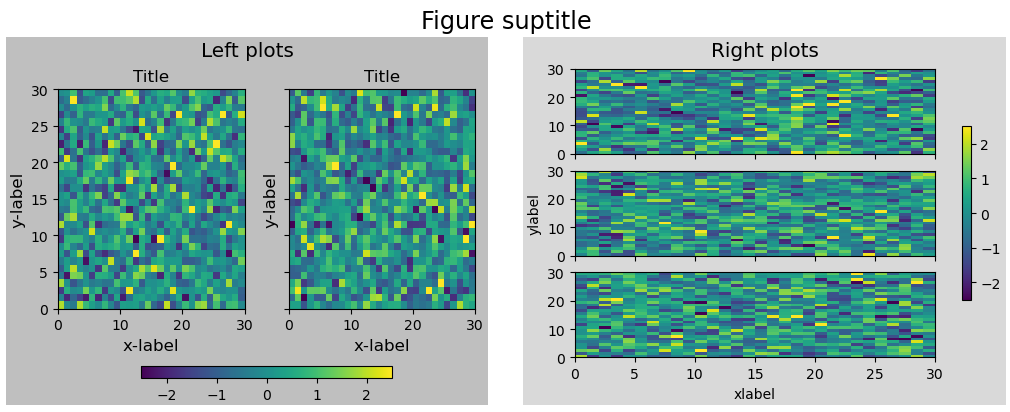

In [1]:
import matplotlib.pyplot as plt
import numpy as np


def example_plot(ax, fontsize=12, hide_labels=False):
    pc = ax.pcolormesh(np.random.randn(30, 30), vmin=-2.5, vmax=2.5)
    if not hide_labels:
        ax.set_xlabel('x-label', fontsize=fontsize)
        ax.set_ylabel('y-label', fontsize=fontsize)
        ax.set_title('Title', fontsize=fontsize)
    return pc

np.random.seed(19680808)
# gridspec inside gridspec
fig = plt.figure(layout='constrained', figsize=(10, 4))
subfigs = fig.subfigures(1, 2, wspace=0.07)

axsLeft = subfigs[0].subplots(1, 2, sharey=True)
subfigs[0].set_facecolor('0.75')
for ax in axsLeft:
    pc = example_plot(ax)
subfigs[0].suptitle('Left plots', fontsize='x-large')
subfigs[0].colorbar(pc, shrink=0.6, ax=axsLeft, location='bottom')

axsRight = subfigs[1].subplots(3, 1, sharex=True)
for nn, ax in enumerate(axsRight):
    pc = example_plot(ax, hide_labels=True)
    if nn == 2:
        ax.set_xlabel('xlabel')
    if nn == 1:
        ax.set_ylabel('ylabel')

subfigs[1].set_facecolor('0.85')
subfigs[1].colorbar(pc, shrink=0.6, ax=axsRight)
subfigs[1].suptitle('Right plots', fontsize='x-large')

fig.suptitle('Figure suptitle', fontsize='xx-large')

plt.show()

In [24]:
import torch
def plot_params(params_out : list[dict[str, torch.Tensor]], params_true : list[dict[str, torch.Tensor]], epoch : int = 0, extension = "") :
        #unwind the parameters into a numpy array
        #first we extract the keys which will be the title of the graph
        keys = list(params_out[0])
        
        #all lengths should be the same
        length_inside_keys = params_out[0].get(keys[0]).size()[0] #type: ignore

        #then we can add the values to the array
        values_out = np.zeros((len(params_out), len(keys), length_inside_keys))
        for i, param in enumerate(params_out) :
            for j, key in enumerate(keys) :
                values_out[i, j] = param[key]
                
        values_true = np.zeros((len(params_true), len(keys), length_inside_keys))      
        for i, param in enumerate(params_true) :
            for j, key in enumerate(keys) :
                values_true[i, j] = param[key]
                
        #we will compute the mean and std of the value along the first dimension
        values_out_mean = values_out.mean(axis=0)
        values_out_std = values_out.std(axis=0)
        
        values_true_mean = values_true.mean(axis=0)
        values_true_std = values_true.std(axis=0)
                

        fig, axs = plt.subplots(len(keys) // 2, 2, layout='constrained', figsize=(10, 4))
        
        for i, key in enumerate(keys) :
            print("subfigs[{:d}]".format(i))
            #we will plot the mean and std as a shaded area
            axs.flat[i].plot(values_true_mean[i], label="True " + key)
            axs.flat[i].fill_between(np.arange(length_inside_keys), values_true_mean[i] - values_true_std[i], values_true_mean[i] + values_true_std[i], alpha=0.5)
            
            axs.flat[i].plot(values_out_mean[i], label="Predicted " + key)
            axs.flat[i].fill_between(np.arange(length_inside_keys), values_out_mean[i] - values_out_std[i], values_out_mean[i] + values_out_std[i], alpha=0.5)
                
            axs.flat[i].legend(loc="upper left", fontsize="xx-small")
            
            axs.flat[i].set_yscale("log")
            
        fig.canvas.draw()
        
        fig.suptitle('Parameters evolution at epoch {:d}'.format(epoch), fontsize='xx-large')
        
        plt.savefig("models/Params{:s}_{:d}.pdf".format(extension, epoch), format="pdf")
        plt.close()

In [25]:
params_out = [{"a" : torch.tensor([1, 2, 3]), "b" : torch.tensor([4, 5, 6]), "c" : torch.tensor([7, 8, 9]), "d" : torch.tensor([10, 11, 12])}, {"a" : torch.tensor([1, 2, 3]), "b" : torch.tensor([4, 5, 6]), "c" : torch.tensor([7, 8, 9]), "d" : torch.tensor([10, 11, 12])}, {"a" : torch.tensor([1, 2, 3]), "b" : torch.tensor([4, 5, 6]), "c" : torch.tensor([7, 8, 9]), "d" : torch.tensor([10, 11, 12])}]
params_true = [{"a" : torch.tensor([1, 2, 3]), "b" : torch.tensor([4, 5, 6]), "c" : torch.tensor([7, 8, 9]), "d" : torch.tensor([10, 11, 12])}, {"a" : torch.tensor([1, 2, 3]), "b" : torch.tensor([4, 5, 6]), "c" : torch.tensor([7, 8, 9]), "d" : torch.tensor([10, 11, 12])}, {"a" : torch.tensor([1, 2, 3]), "b" : torch.tensor([4, 5, 6]), "c" : torch.tensor([7, 8, 9]), "d" : torch.tensor([10, 11, 12])}]

In [26]:
plot_params(params_out, params_true)

subfigs[0]
subfigs[1]
subfigs[2]
subfigs[3]
